In [1]:
# connect to google drive, run this block again after every restart of runtime
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/GCN_model_1107')

Mounted at /content/drive


In [2]:
# review (only review) GPU information, run when needed
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 26 02:20:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import csv
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Lambda, Flatten, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.math import multiply
from tensorflow.math import sign
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# from utils import *
from keras_dgl.layers import MultiGraphCNN

In [4]:
def normalize_adj_numpy(adj, symmetric=False):
    if symmetric:
        d = np.diag(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d)
    else:
        d = np.diag(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj)
    return a_norm

def preprocess_adj_tensor_concat(adj_tensor, symmetric=False):
    adj_out_tensor = []
    for i in range(adj_tensor.shape[0]):
        adj = adj_tensor[i]
        ################################
        # adj = adj + np.eye(adj.shape[0])
        ################################
        # adj = normalize_adj_numpy(adj, symmetric)
        ################################
        adj_out_tensor.append(adj)
    adj_out_tensor = np.concatenate(adj_out_tensor, axis=0)
    return adj_out_tensor

def preprocess_edge_adj_tensor(edge_adj_tensor, symmetric=False):
    edge_adj_out_tensor = []
    # num_edge_features = int(edge_adj_tensor.shape[1]/edge_adj_tensor.shape[2])
    num_edge_features = edge_adj_tensor.shape[3]

    for i in range(edge_adj_tensor.shape[0]):
        edge_adj = edge_adj_tensor[i]
        # edge_adj = np.split(edge_adj, num_edge_features, axis=0)
        edge_adj = np.array(edge_adj)
        edge_adj = preprocess_adj_tensor_concat(edge_adj, symmetric)
        edge_adj_out_tensor.append(edge_adj)

    edge_adj_out_tensor = np.array(edge_adj_out_tensor)
    return edge_adj_out_tensor

In [5]:
GCN_npz_name = "/content/drive/MyDrive/GCN_model_1107/GCN_2400_train_0601.npz"
data = np.load(GCN_npz_name)
node, edge, label = data['arr_0'], data['arr_1'], data['arr_2']

In [6]:
node[100]

array([[ 0.    ,  0.    ,  0.    ,  1.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
       [ 5.75  ,  6.5   , 37.375 ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 7.75  ,  4.5   , 34.875 ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 7.75  ,  4.25  , 32.9375,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 5.75  ,  5.75  , 33.0625,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 7.75  ,  3.5   , 27.125 ,  0.    ,  0.    ,  0.    ,  0.    ]])

<Axes: >

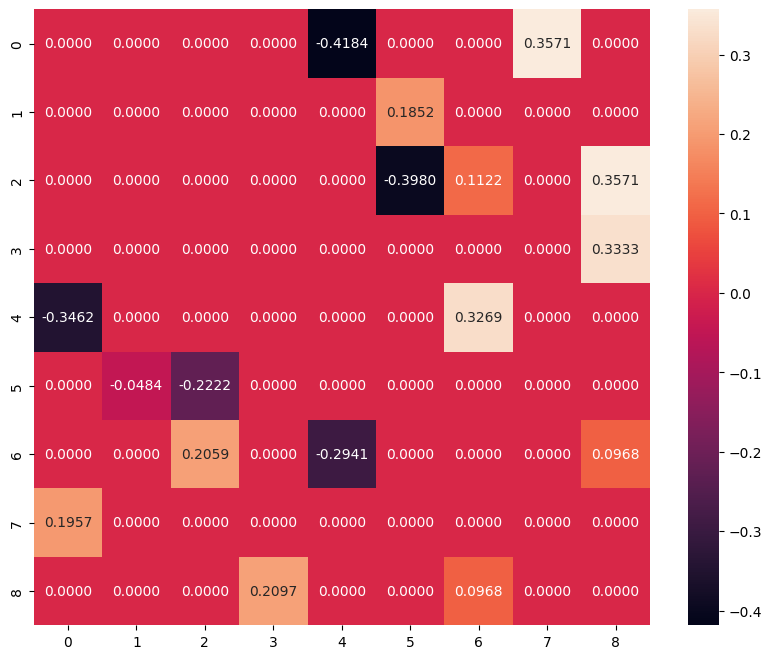

In [7]:
# [h_dim, v_dim, area, h_shift, v_shift, W, S, E, N]
mx = edge[100][3,:,:]
fig= plt.figure(figsize=(10, 8))
sns.heatmap(mx, annot=True, fmt=".4f", square=True)

<Axes: >

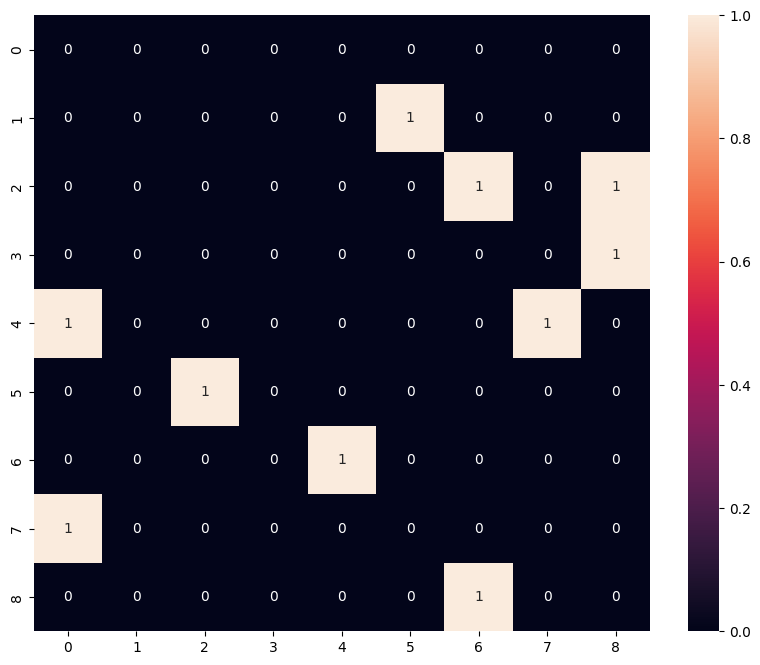

In [8]:
lmx = label[100]
fig= plt.figure(figsize=(10, 8))
sns.heatmap(lmx, annot=True, square=True)

In [9]:
# prepare data
A = np.array(edge)
X = np.array(node)
Y = np.array(label)
print("A shape: ", A.shape)
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
num_graphs = A.shape[0]
num_edge_features = A.shape[1]
num_graph_nodes = A.shape[2]
print("num_graphs: ", num_graphs)
print("num_edge_features: ", num_edge_features)
print("num_graph_nodes: ", num_graph_nodes)

A shape:  (2400, 9, 9, 9)
X shape:  (2400, 9, 7)
Y shape:  (2400, 9, 9)
num_graphs:  2400
num_edge_features:  9
num_graph_nodes:  9


In [10]:
Y[100]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [ ]:
# A, X, Y = shuffle(A, X, Y)

In [11]:
# build graph_conv_filters
SYM_NORM = False
num_filters = num_edge_features
graph_conv_filters = preprocess_edge_adj_tensor(A, SYM_NORM)
print(graph_conv_filters.shape)

(2400, 81, 9)


<Axes: >

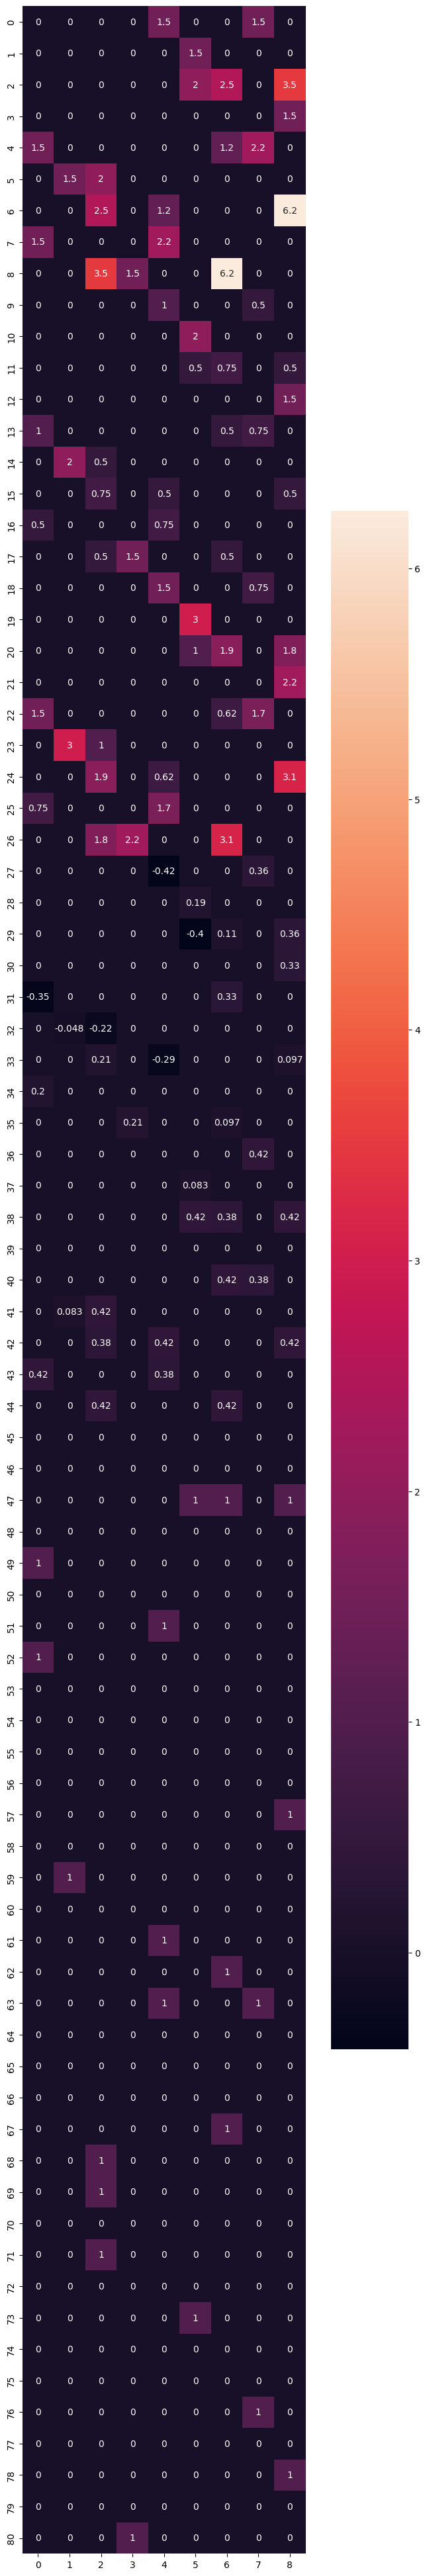

In [12]:
fig= plt.figure(figsize=(10, 50))
sns.heatmap(graph_conv_filters[100], annot=True, square=True)

In [13]:
# build model (model_0801)
num_node = 64
X_input = Input(shape=(X.shape[1], X.shape[2]))
graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))

output = Flatten()(X_input)
output = Dense(X.shape[1]*num_node, activation='elu')(output)
output = Dense(X.shape[1]*num_node, activation='elu')(output)
output = Reshape((X.shape[1], num_node))(output)

output = MultiGraphCNN(num_node*4, num_filters, activation='elu')([output, graph_conv_filters_input])
output = Dropout(0.5)(output)

output = Flatten()(output)
output = Dense(X.shape[1]*num_node, activation='elu')(output)
output = Dense(X.shape[1]*num_node, activation='elu')(output)
output = Reshape((X.shape[1], num_node))(output)

output = MultiGraphCNN(num_node*4, num_filters, activation='elu')([output, graph_conv_filters_input])
output = Dropout(0.5)(output)

output = Flatten()(output)
output = Dense(X.shape[1]*num_node, activation='elu')(output)
output = Dense(X.shape[1]*num_node, activation='elu')(output)
output = Reshape((X.shape[1], num_node))(output)

output = MultiGraphCNN(num_node*4, num_filters, activation='elu')([output, graph_conv_filters_input])
output = Dropout(0.5)(output)

output = Flatten()(output)
output = Dense(X.shape[1]*num_node, activation='elu')(output)
output = Dense(X.shape[1]*num_node, activation='elu')(output)
output = Reshape((X.shape[1], num_node))(output)

output = MultiGraphCNN(Y.shape[2], num_filters, activation='sigmoid')([output, graph_conv_filters_input])

In [14]:
model = Model(inputs=[X_input, graph_conv_filters_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['acc']) # lr start with 0.0001
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9, 7)]       0           []                               
                                                                                                  
 flatten (Flatten)              (None, 63)           0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 576)          36864       ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 576)          332352      ['dense[0][0]']                  
                                                                                              

In [15]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 50 == 0 and epoch > 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save("/content/drive/MyDrive/GCN_model_1107/model_archive/0801/GCN_model_0801_{}.h5".format(epoch))

In [ ]:
nb_epochs = 4000
batch_size = 256
saver = CustomSaver()
history_callback  = model.fit([X, graph_conv_filters], Y, batch_size=batch_size, validation_split=0.01, epochs=nb_epochs, callbacks=[saver], shuffle=True, verbose=1)
cur_filename = "/content/drive/MyDrive/GCN_model_1107/model_archive/0801/GCN_model_0801_" + str(nb_epochs) + ".h5"
model.save(cur_filename)

Streaming output truncated to the last 5000 lines.
Epoch 1501/4000
10/10 [==============================] - 2s 168ms/step - loss: 0.0139 - acc: 0.7259 - val_loss: 0.1654 - val_acc: 0.7037
Epoch 1502/4000
10/10 [==============================] - 0s 11ms/step - loss: 0.0140 - acc: 0.7216 - val_loss: 0.1707 - val_acc: 0.7037
Epoch 1503/4000
10/10 [==============================] - 0s 10ms/step - loss: 0.0139 - acc: 0.7235 - val_loss: 0.1745 - val_acc: 0.7037
Epoch 1504/4000
10/10 [==============================] - 0s 11ms/step - loss: 0.0138 - acc: 0.7235 - val_loss: 0.1802 - val_acc: 0.6898
Epoch 1505/4000
10/10 [==============================] - 0s 11ms/step - loss: 0.0139 - acc: 0.7206 - val_loss: 0.1837 - val_acc: 0.6944
Epoch 1506/4000
10/10 [==============================] - 0s 10ms/step - loss: 0.0139 - acc: 0.7207 - val_loss: 0.1772 - val_acc: 0.6944
Epoch 1507/4000
10/10 [==============================] - 0s 10ms/step - loss: 0.0139 - acc: 0.7227 - val_loss: 0.1749 - val_acc: 0.6

In [22]:
# Training result on 0316 is better than 0801, use 0316 as Organizer

# filename = "/content/drive/MyDrive/GCN_model_1107/model_archive/0801/GCN_model_0801_1300.h5"
filename = "/content/drive/MyDrive/GCN_model_1107/model_archive/0316/GCN_model_0316_1300.h5"
model = load_model(filename, custom_objects={'MultiGraphCNN': MultiGraphCNN}, compile=False)

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['acc'])

In [ ]:
train_loss = history_callback.history['loss']
val_loss   = history_callback.history['val_loss']
acc = history_callback.history['acc']
val_acc = history_callback.history['val_acc']
his_df = pd.DataFrame({'loss':train_loss, 'val_loss':val_loss, 'acc':acc, 'val_acc': val_acc})
total_epochs = 4000
his_df.to_csv("/content/drive/MyDrive/GCN_model_1107/GCN_model_0801_" + str(total_epochs) + ".csv")

Text(0.5, 1.0, 'val_accuracy')

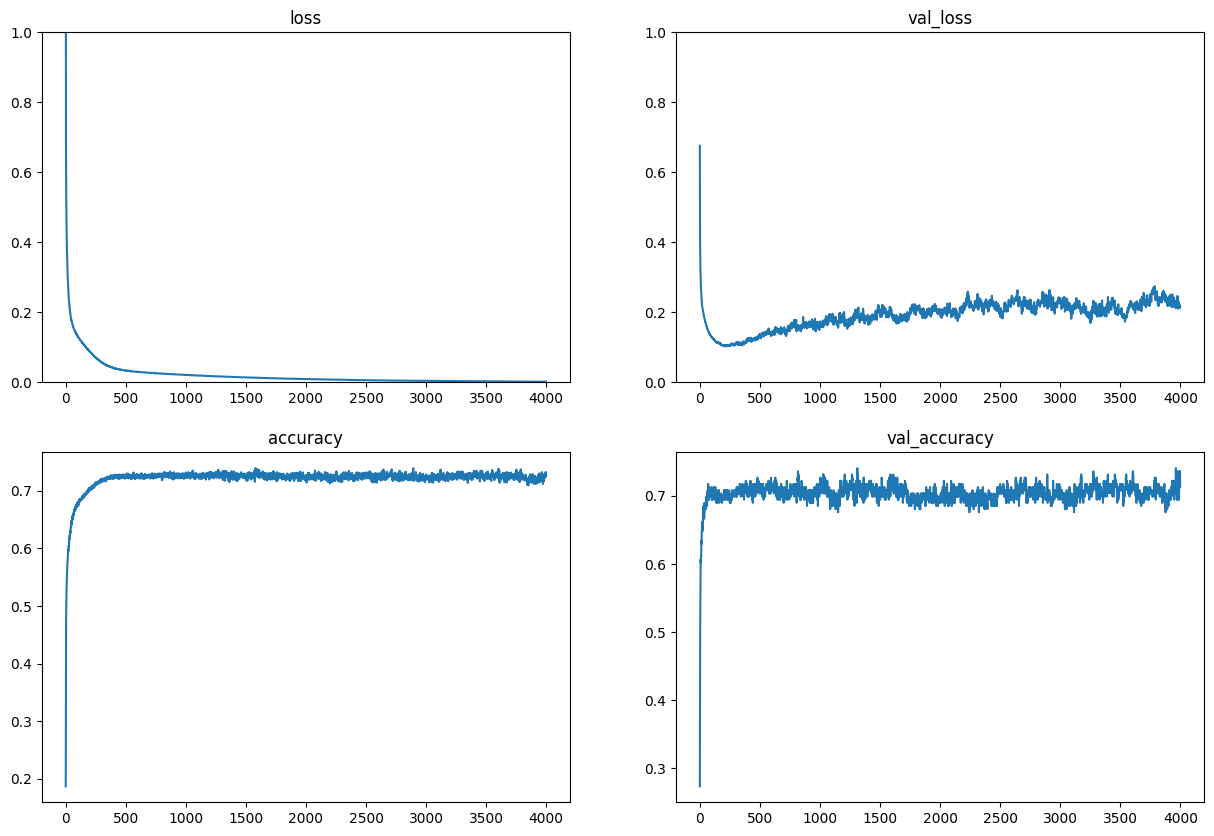

In [21]:
his_file = "/content/drive/MyDrive/GCN_model_1107/GCN_model_0316_4000.csv"
# his_file = "/content/drive/MyDrive/GCN_model_1107/GCN_model_0801_4000.csv"
history = pd.read_csv(his_file)
train_loss = history['loss']
val_loss   = history['val_loss']
acc = history['acc']
val_acc = history['val_acc']
his_df = pd.DataFrame({'loss':train_loss, 'val_loss':val_loss, 'acc':acc, 'val_acc': val_acc})
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
his_df['loss'].plot(ax=ax[0,0]); ax[0,0].set_title('loss'); ax[0,0].set_ylim(0.0, 1.0)
his_df['val_loss'].plot(ax=ax[0,1]); ax[0,1].set_title('val_loss'); ax[0,1].set_ylim(0.0, 1.0)
his_df['acc'].plot(ax=ax[1,0]); ax[1,0].set_title('accuracy')
his_df['val_acc'].plot(ax=ax[1,1]); ax[1,1].set_title('val_accuracy')

In [23]:
def Calculate_pred_post(pred, GC_filters):
    pred_post = np.zeros(pred.shape)
    locator = GC_filters[18:27, :]
    rm_dim = pred.shape[0]
    if not pred.shape[0] == pred.shape[1]:
        print("Predicted matrix has different column and row dimensions!")

    for i in range(rm_dim):
        for j in range(i+1, rm_dim):
            if not locator[i,j] == 0 and not i==j:
                if pred[i,j] > pred[j,i]:
                    pred_post[i,j] = 1
                    pred_post[j,i] = 0
                elif pred[i,j] < pred[j,i]:
                    pred_post[i,j] = 0
                    pred_post[j,i] = 1
                else:
                    pred_post[i,j] = 0
                    pred_post[j,i] = 0

    for i in range(4, pred.shape[0]):
        if sum(pred_post[i,:]) == 0:
            pred_nzero = np.where(locator > 0.0, pred, 0.0)
            j = np.argmax(pred_nzero[i,:])
            pred_post[i,j] = 1
            pred_post[j,i] = 0

    return pred_post

In [24]:
ind = 2388
X_0, graph_conv_filters_0 = X[ind:ind+1], graph_conv_filters[ind:ind+1]
Y_0 = Y[ind]
pred_0 = model.predict([X_0, graph_conv_filters_0])[0]
pred_post_0 = Calculate_pred_post(pred_0, graph_conv_filters_0[0])

1/1 [==============================] - 3s 3s/step


<Axes: >

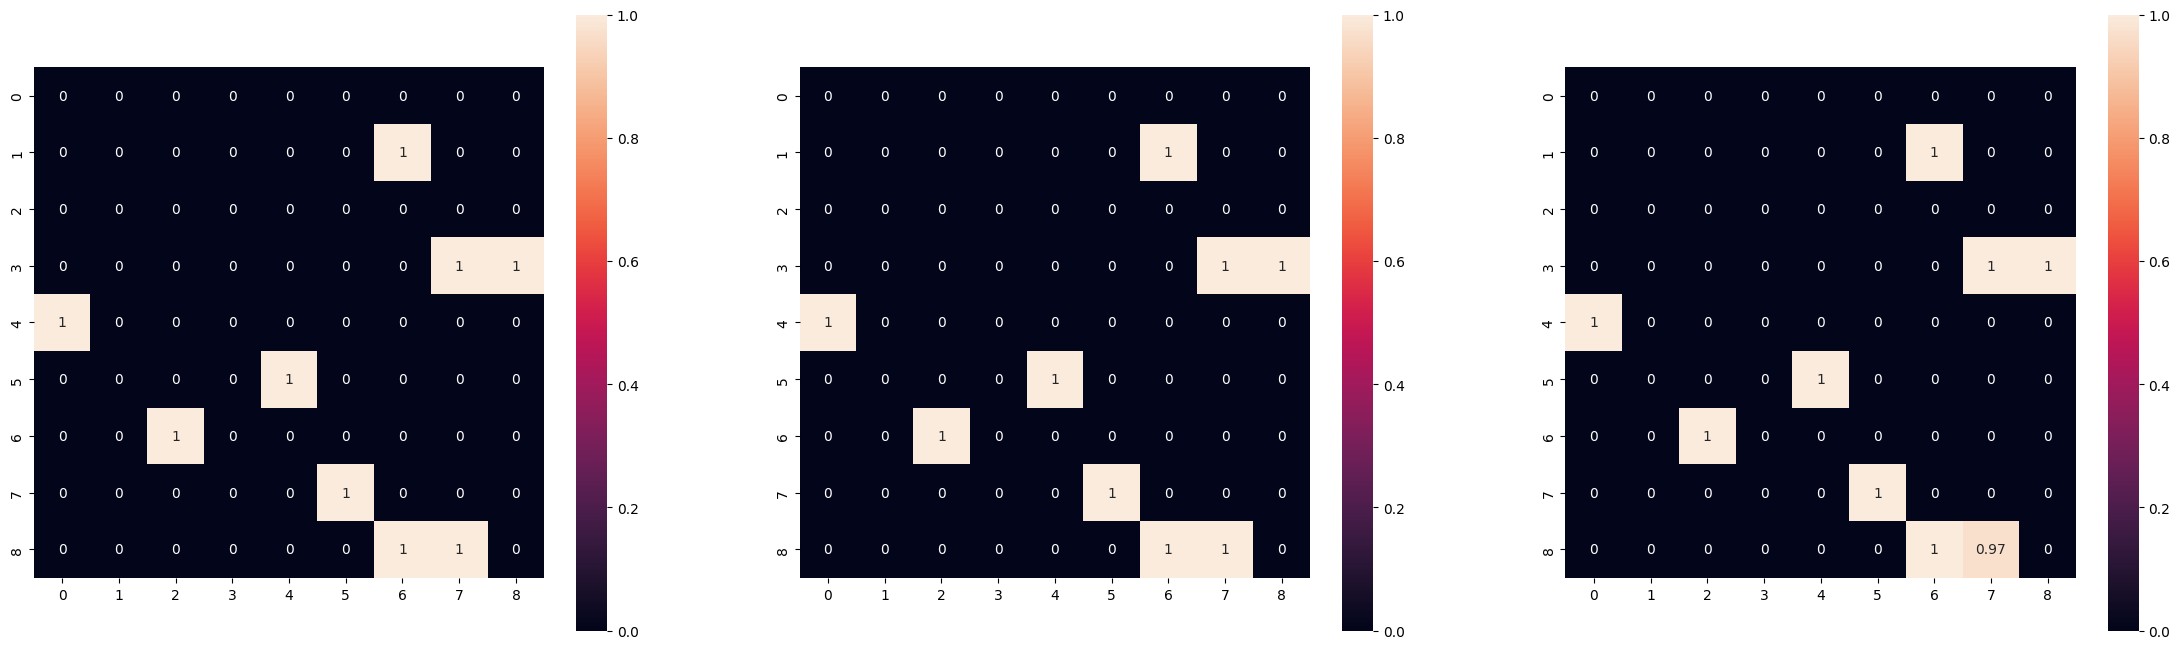

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 8))
sns.heatmap(Y_0, annot=True, ax = ax[0], square=True)
sns.heatmap(np.round(pred_post_0, 2), annot=True, ax = ax[1], square=True)
sns.heatmap(np.round(pred_0, 2), annot=True, ax = ax[2], square=True)

In [ ]:
eps = 0.001
num_edge_list = []
num_wrong_list = []
accuracy_list = []
ind_list = range(2376, 2400)
# ind_list = range(2376)
for i in ind_list:
  X_i, graph_conv_filters_i = X[i:i+1], graph_conv_filters[i:i+1]
  Y_i = Y[i]
  pred_i = model.predict([X_i, graph_conv_filters_i])[0]
  pred_post_i = Calculate_pred_post(pred_i, graph_conv_filters_i[0])
  num_edge = np.sum(Y_i).astype('int')
  num_wrong = (np.sum((np.abs(Y_i - pred_post_i) > eps).astype('int'))/2).astype('int')
  num_edge_list.append(num_edge)
  num_wrong_list.append(num_wrong)
  accuracy_list.append((num_edge-num_wrong)/num_edge)
d = {'num_edge': num_edge_list, 'num_wrong': num_wrong_list, 'accuracy': accuracy_list}
df = pd.DataFrame(data=d, index=ind_list)
df

1/1 [==============================] - 0s 20ms/step


,num_edge,num_wrong,accuracy
2376,10,1,0.900000
2377,9,2,0.777778
2378,9,0,1.000000
2379,9,0,1.000000
2380,10,0,1.000000
2381,10,0,1.000000
2382,11,1,0.909091
2383,10,1,0.900000
2384,11,0,1.000000
2385,8,0,1.000000


0.9104583333333334
39


array([[<Axes: title={'center': 'accuracy'}>]], dtype=object)

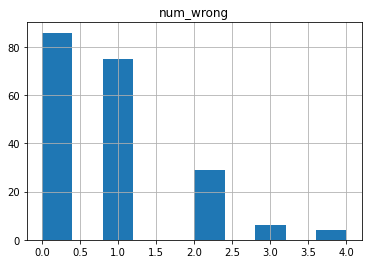

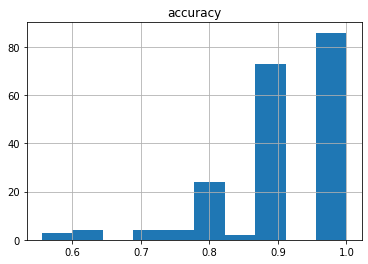

In [ ]:
print(df['accuracy'].mean())
print(len(df.loc[df.num_wrong > 1]))
# df.loc[df.num_wrong > 1]
df.hist(column="num_wrong")
df.hist(column="accuracy")

In [26]:
# 600 test dataset
GCN_test_npz_name = "/content/drive/MyDrive/GCN_model_1107/GCN_600_test_0602.npz"
test_data = np.load(GCN_test_npz_name)
test_node, test_edge, test_label = test_data['arr_0'], test_data['arr_1'], test_data['arr_2']
A_test, X_test, Y_test = np.array(test_edge), np.array(test_node), np.array(test_label)
print("A_test shape: ", A_test.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)
SYM_NORM = False
# num_filters = num_edge_features
graph_conv_filters_test = preprocess_edge_adj_tensor(A_test, SYM_NORM)
print(graph_conv_filters_test.shape)

A_test shape:  (600, 9, 9, 9)
X_test shape:  (600, 9, 7)
Y_test shape:  (600, 9, 9)
(600, 81, 9)


In [27]:
eps = 0.001
num_edge_list = []
num_wrong_list = []
accuracy_list = []
ind_list = range(600)
for i in ind_list:
  X_i, graph_conv_filters_i = X_test[i:i+1], graph_conv_filters_test[i:i+1]
  Y_i = Y_test[i]
  pred_i = model.predict([X_i, graph_conv_filters_i])[0]
  pred_post_i = Calculate_pred_post(pred_i, graph_conv_filters_i[0])
  num_edge = np.sum(Y_i).astype('int')
  num_wrong = (np.sum((np.abs(Y_i - pred_post_i) > eps).astype('int'))/2).astype('int')
  num_edge_list.append(num_edge)
  num_wrong_list.append(num_wrong)
  accuracy_list.append((num_edge-num_wrong)/num_edge)
d = {'num_edge': num_edge_list, 'num_wrong': num_wrong_list, 'accuracy': accuracy_list}
df = pd.DataFrame(data=d, index=ind_list)

1/1 [==============================] - 0s 24ms/step


0.9269340428090428
76


<ipython-input-28-875a24afdaf7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals1/600])
<ipython-input-28-875a24afdaf7>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals2/600])


Text(0.5, 1.0, 'Statistic of prediction accuracy \n (out of 600 test data points)')

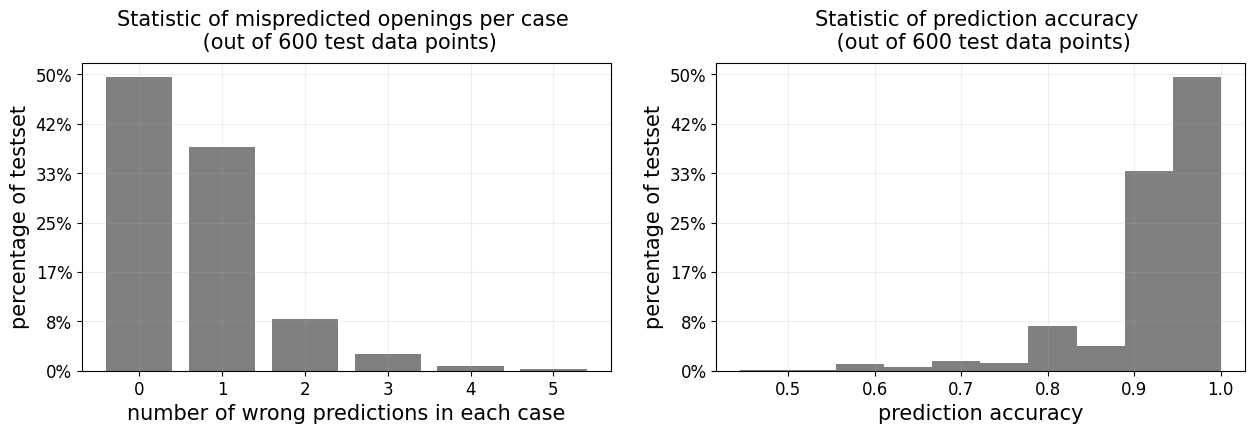

In [28]:
print(df['accuracy'].mean())
print(len(df.loc[df.num_wrong > 1]))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

axs[0].bar(df["num_wrong"].value_counts().keys(), df["num_wrong"].value_counts().values, color='grey')
axs[0].grid(alpha=0.2)
vals1 = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals1/600])
axs[0].tick_params(axis='both', labelsize=12)
axs[0].set_ylabel('percentage of testset', fontsize=15)
axs[0].set_xlabel('number of wrong predictions in each case', fontsize=15)
axs[0].set_title('Statistic of mispredicted openings per case \n (out of 600 test data points)', fontsize=15, pad = 10)

axs[1].hist(df["accuracy"], color='grey')
axs[1].grid(alpha=0.2)
vals2 = axs[1].get_yticks()
axs[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals2/600])
axs[1].tick_params(axis='both', labelsize=12)
axs[1].set_ylabel('percentage of testset', fontsize=15)
axs[1].set_xlabel('prediction accuracy', fontsize=15)
axs[1].set_title('Statistic of prediction accuracy \n (out of 600 test data points)', fontsize=15, pad = 10)

In [ ]:
eps = 0.001
ind_list = range(600)

mean_acc_list = []
total_wrong_list = []
for k in range(50, 4050, 50):
    filename = "/content/drive/MyDrive/GCN_model_1107/model_archive/0801/GCN_model_0801_" + str(k) + ".h5"
    model = load_model(filename, custom_objects={'MultiGraphCNN': MultiGraphCNN}, compile=False)

    num_edge_list = []
    num_wrong_list = []
    accuracy_list = []

    for i in ind_list:
        X_i, graph_conv_filters_i = X_test[i:i+1], graph_conv_filters_test[i:i+1]
        Y_i = Y_test[i]
        pred_i = model.predict([X_i, graph_conv_filters_i])[0]
        pred_post_i = Calculate_pred_post(pred_i, graph_conv_filters_i[0])
        num_edge = np.sum(Y_i).astype('int')
        num_wrong = (np.sum((np.abs(Y_i - pred_post_i) > eps).astype('int'))/2).astype('int')
        num_edge_list.append(num_edge)
        num_wrong_list.append(num_wrong)
        accuracy_list.append((num_edge-num_wrong)/num_edge)
    d = {'num_edge': num_edge_list, 'num_wrong': num_wrong_list, 'accuracy': accuracy_list}
    df = pd.DataFrame(data=d, index=ind_list)

    mean_acc_list.append(df['accuracy'].mean())
    total_wrong_list.append(len(df.loc[df.num_wrong > 1]))
np.savetxt("/content/drive/MyDrive/GCN_model_1107/mean_acc_list_0801.csv", np.array(mean_acc_list).T, delimiter = ",")
np.savetxt("/content/drive/MyDrive/GCN_model_1107/total_wrong_list_0801.csv", np.array(total_wrong_list).T, delimiter = ",")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step


<ipython-input-18-8d2cbb46838c>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals2/600])


Text(0.5, 1.0, 'percentage of cases with wrong prediction > 1 ')

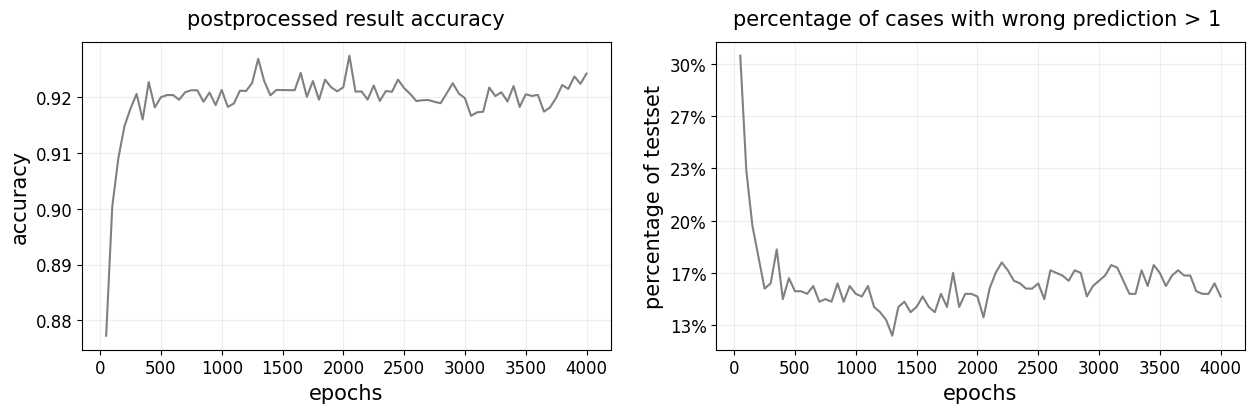

In [18]:
mean_acc_list = np.loadtxt("/content/drive/MyDrive/GCN_model_1107/mean_acc_list.csv", dtype=float)
total_wrong_list = np.loadtxt("/content/drive/MyDrive/GCN_model_1107/total_wrong_list.csv", dtype=float).astype(int)
#mean_acc_list = np.loadtxt("/content/drive/MyDrive/GCN_model_1107/mean_acc_list_0801.csv", dtype=float)
#total_wrong_list = np.loadtxt("/content/drive/MyDrive/GCN_model_1107/total_wrong_list_0801.csv", dtype=float).astype(int)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

axs[0].plot(range(50, 4050, 50), mean_acc_list, color='grey')
axs[0].grid(alpha=0.2)
axs[0].tick_params(axis='both', labelsize=12)
axs[0].set_ylabel('accuracy', fontsize=15)
axs[0].set_xlabel('epochs', fontsize=15)
axs[0].set_title('postprocessed result accuracy', fontsize=15, pad = 12)

axs[1].plot(range(50, 4050, 50), total_wrong_list, color='grey')
axs[1].grid(alpha=0.2)
vals2 = axs[1].get_yticks()
axs[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals2/600])
axs[1].tick_params(axis='both', labelsize=12)
axs[1].set_ylabel('percentage of testset', fontsize=15)
axs[1].set_xlabel('epochs', fontsize=15)
axs[1].set_title('percentage of cases with wrong prediction > 1 ', fontsize=15, pad = 12)

In [ ]:
mean_acc_list

array([0.87402573, 0.89587452, 0.90787175, 0.91327201, 0.91616889,
       0.91952609, 0.9218346 , 0.92149116, 0.91880255, 0.91853992,
       0.91712536, 0.91706475, 0.91847427, 0.91787103, 0.91845196,
       0.91606884, 0.9183058 , 0.91708147, 0.91671362, 0.91691101,
       0.91839502, 0.91713324, 0.91712987, 0.91795984, 0.91703403,
       0.91867881, 0.91752477, 0.91770268, 0.91914628, 0.91853151,
       0.91863282, 0.91971489, 0.9188744 , 0.91798846, 0.91942911,
       0.91846447, 0.91820857, 0.91850613, 0.91572878, 0.91711935,
       0.91889755, 0.91700403, 0.91664755, 0.91638071, 0.92007768,
       0.91622288, 0.91858442, 0.91800192, 0.91713071, 0.91884073,
       0.91940386, 0.91834283, 0.91859999, 0.91835053, 0.91990049,
       0.91705592, 0.92024645, 0.91869805, 0.92154022, 0.9188946 ,
       0.9185656 , 0.92032642, 0.91965302, 0.92047078, 0.92062103,
       0.91884536, 0.91987482, 0.9174691 , 0.91886472, 0.91807684,
       0.92015554, 0.9196161 , 0.92081181, 0.91789081, 0.92291

In [ ]:
total_wrong_list

array([198, 150, 127, 115, 107, 105,  94,  98, 103, 103, 102, 104,  99,
       104, 104, 111, 106, 107, 113, 105, 105, 104, 103, 102, 109, 103,
       106, 108, 101, 101, 100, 101, 101, 100, 108, 108, 104, 107, 109,
       109, 105, 101, 107, 109, 100, 113, 110, 104, 109, 107,  99,  99,
       101, 100,  98, 109, 107, 111, 101, 107, 110, 102, 105, 102, 102,
        99, 100, 109, 101, 103, 105,  97, 101, 102,  98,  97,  99, 100,
        99, 102])